<a href="https://colab.research.google.com/github/stonewallmhk/QuantMindi/blob/main/ModernPortfolioTheory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimization

In [20]:
# on average there are 252 trading days in a year
NUM_TRADING_DAYS = 252

NUM_PORTFOLIOS = 10000

# stocks to handle
stocks = ['AAPL','WMT','TSLA','GE','AMZN','DB']

# Historical data
start_date = '2010-01-01'
end_date = '2017-01-01'

def download_data():
  #name of the stock (key) - stock values (2010-2017)
  stock_data = {}

  for stock in stocks:
    ticker = yf.Ticker(stock) 
    stock_data[stock] = ticker.history(start=start_date, end=end_date)['Close']

  return pd.DataFrame(stock_data)

def show_data(data):
    data.plot(figsize=(10, 5))
    plt.show()

def calculate_returns(data):
  #Normalization of returns
  log_return = np.log(data/data.shift(1))
  return log_return[1:]

def show_mean_variance(returns, weights):
  # Annual returns
  portfolio_returns = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
  
  # portfolio volatility = SQRT(W^t (weights transposed) * (Covariance Matrix) * W (weights))
  portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * NUM_TRADING_DAYS, weights)))

  print("Expected Portfolio Mean (returns): ", portfolio_returns)
  print("Expected Portfolio Volatility (STD): ", portfolio_volatility)

def show_portfolios(returns, volatilities):
  plt.figure(figsize=(10, 6))
  plt.scatter(volatilities, returns, c=returns / volatilities, marker='o')
  plt.grid(True)
  plt.xlabel('Expected Volatility')
  plt.ylabel('Expected Return')
  plt.colorbar(label='Sharpe Ratio')
  plt.show()

def generate_portfolios(returns):
  portfolio_means = []
  portfolio_risks = []
  portfolio_weights = []

  for _ in range(NUM_PORTFOLIOS):
    w = np.random.random(len(stocks))
    w /= np.sum(w)
    portfolio_weights.append(w)
    portfolio_means.append(np.sum(returns.mean() * w) * NUM_TRADING_DAYS)
    portfolio_risks.append(np.sqrt(np.dot(w.T, np.dot(returns.cov()
                                                      * NUM_TRADING_DAYS, w))))

  return np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risks)

def statistics(weights, returns):
  portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
  portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov()
                                                          * NUM_TRADING_DAYS, weights)))
  return np.array([portfolio_return, portfolio_volatility,
                    portfolio_return / portfolio_volatility])


# scipy optimize module can find the minimum of a given function
# the maximum of a f(x) is the minimum of -f(x)
def min_function_sharpe(weights, returns):
  return -statistics(weights, returns)[2]

# what are the constraints? The sum of weights = 1 !!!
# f(x)=0 this is the function to minimize
def optimize_portfolio(weights, returns):
  # the sum of weights is 1
  constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
  # the weights can be 1 at most: 1 when 100% of money is invested into a single stock
  bounds = tuple((0, 1) for _ in range(len(stocks)))
  return optimization.minimize(fun=min_function_sharpe, x0=weights[0], args=returns
                                , method='SLSQP', bounds=bounds, constraints=constraints)


def print_optimal_portfolio(optimum, returns):
  print("Optimal portfolio: ", optimum['x'].round(3))
  print("Expected return, volatility and Sharpe ratio: ",
        statistics(optimum['x'].round(3), returns))

def show_optimal_portfolio(opt, rets, portfolio_rets, portfolio_vols):
  plt.figure(figsize=(10, 6))
  plt.scatter(portfolio_vols, portfolio_rets, c=portfolio_rets / portfolio_vols, marker='o')
  plt.grid(True)
  plt.xlabel('Expected Volatility')
  plt.ylabel('Expected Return')
  plt.colorbar(label='Sharpe Ratio')
  plt.plot(statistics(opt['x'], rets)[1], statistics(opt['x'], rets)[0], 'g*', markersize=20.0)
  plt.show()

def show_statistics(returns):
  # We need annual returns instead of daily returns
  # mean of annual returns
  print(returns.mean() * NUM_TRADING_DAYS)
  print(returns.cov() * NUM_TRADING_DAYS)

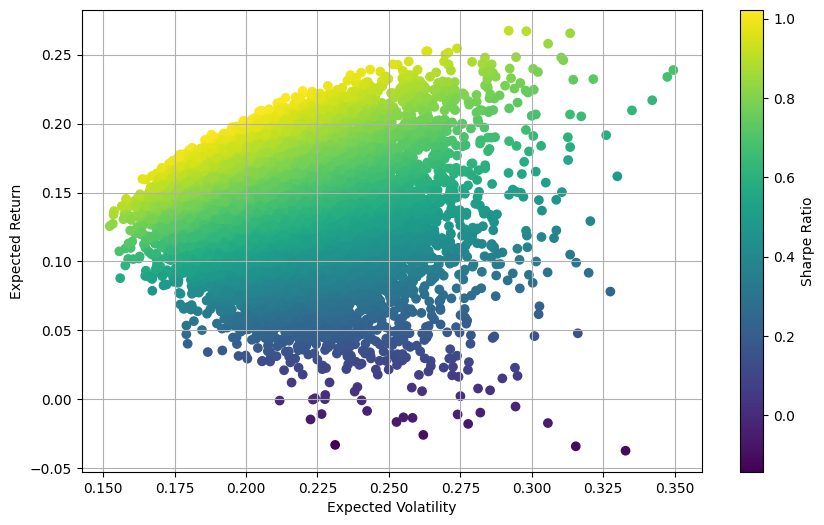

Optimal portfolio:  [0.363 0.075 0.141 0.155 0.265 0.   ]
Expected return, volatility and Sharpe ratio:  [0.21237315 0.20573073 1.03228695]


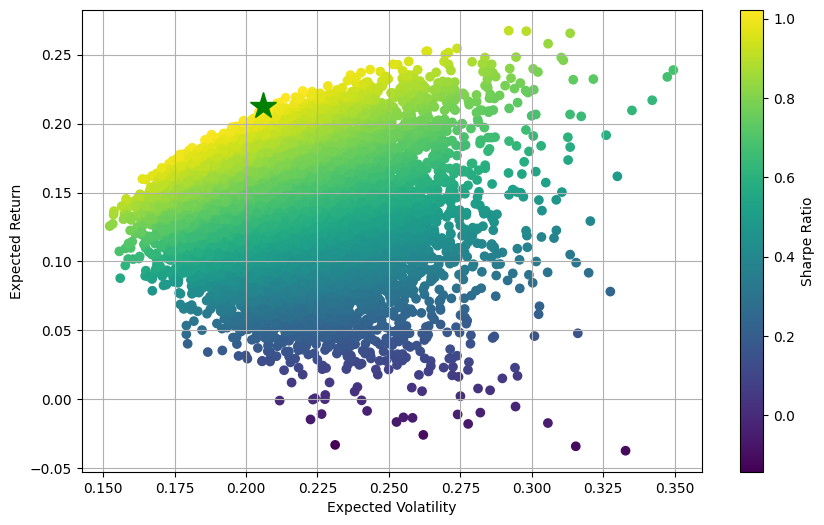

In [21]:
if __name__ =='__main__':
  dataset = download_data()
  #show_data(dataset)
  log_daily_returns = calculate_returns(dataset)
  #show_statistics(log_daily_returns)
  pweights, means, risks = generate_portfolios(log_daily_returns)
  show_portfolios(means, risks)
  optimum = optimize_portfolio(pweights, log_daily_returns)
  print_optimal_portfolio(optimum, log_daily_returns)
  show_optimal_portfolio(optimum, log_daily_returns, means, risks)